In [1]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [2]:
transactions = pd.read_csv("../data/transactions_train.csv")
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


### Feature Selection

#### Encode categorical values

In [3]:
origNames = np.array(transactions["nameOrig"].unique())
destNames = np.array(transactions["nameDest"].unique())
account_names = np.unique(np.concatenate((origNames, destNames)))
account_encoder = LabelEncoder()
account_encoder.fit(account_names)
account_encoder.classes_ = np.append(account_encoder.classes_, "<unknown>")

type_encoder = LabelEncoder()
type_names = transactions["type"].unique()
type_encoder.fit(type_names)
type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")

transactions["nameOrig"] = account_encoder.transform(transactions["nameOrig"])
transactions["nameDest"] = account_encoder.transform(transactions["nameDest"])
transactions["type"]     = type_encoder.transform(transactions["type"])

transactions

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,3,9839.64,824393,170136.00,160296.36,7998496,0.00,0.00,0
1,1,3,1864.28,2380989,21249.00,19384.72,8070214,0.00,0.00,0
2,1,4,181.00,1090175,181.00,0.00,5311503,0.00,0.00,1
3,1,1,181.00,6339178,181.00,0.00,4728056,21182.00,0.00,1
4,1,3,11668.14,3748163,41554.00,29885.86,7166743,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6351188,699,4,162326.52,1991349,162326.52,0.00,4779873,0.00,0.00,1
6351189,699,1,162326.52,1901608,162326.52,0.00,4928330,0.00,162326.52,1
6351190,699,4,2763398.31,5399407,2763398.31,0.00,5549335,0.00,0.00,1
6351191,699,1,2763398.31,1755670,2763398.31,0.00,4958084,339515.35,3102913.66,1


In [4]:
print("Fraud: {:.2f}%".format(len(transactions[transactions["isFraud"] == 1])/len(transactions)*100))
print("Non-fraud: {:.2f}%".format(len(transactions[transactions["isFraud"] == 0])/len(transactions)*100))

Fraud: 0.12%
Non-fraud: 99.88%


#### Correlation Matrix

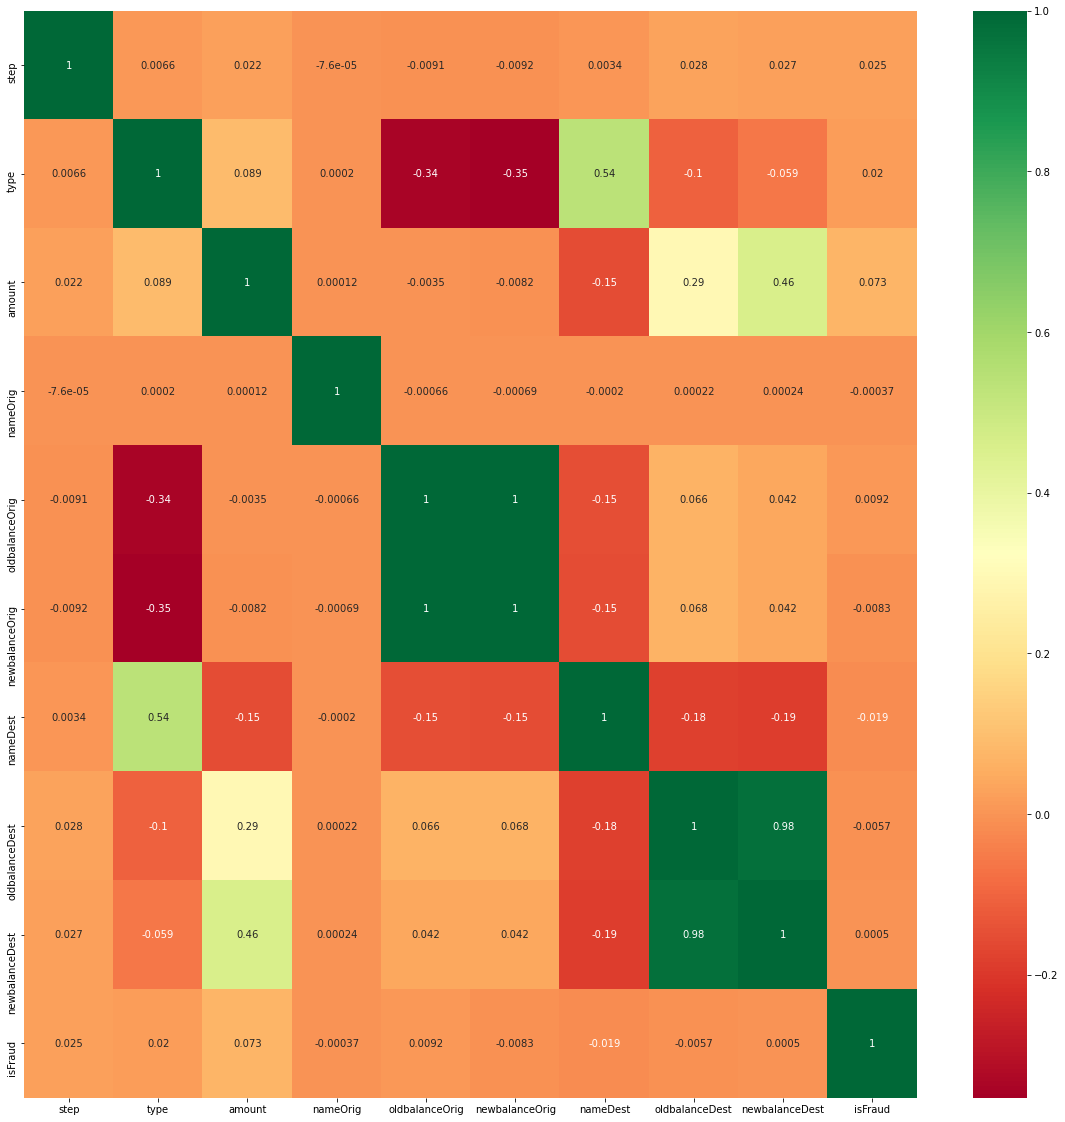

In [5]:
corrmat = transactions.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g = sns.heatmap(transactions[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [6]:
# K-Best features using chi2
from sklearn.feature_selection import SelectKBest, chi2

X = transactions.drop(['isFraud', 'nameDest', 'nameOrig'], axis=1)
Y = transactions["isFraud"]

bestfeatures = SelectKBest(score_func=chi2, k=7)
fit = bestfeatures.fit(X, Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ["Feature", "Score"]
print(featureScores.nlargest(7, "Score"))

          Feature         Score
2          amount  6.923491e+10
3  oldbalanceOrig  5.408668e+09
4  newbalanceOrig  4.398255e+09
5  oldbalanceDest  2.132760e+09
6  newbalanceDest  1.720156e+07
0            step  3.387000e+05
1            type  2.757696e+03


### Train-test split

In [7]:
transactions = pd.read_csv("../data/transactions_train.csv")
X = transactions[["type", "amount", "oldbalanceOrig", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]]
Y = transactions["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print("y_train Fraud: {:.2f}%".format(y_train.value_counts()[0]/len(y_train)*100))
print("y_train Non-fraud: {:.2f}%".format(y_train.value_counts()[1]/len(y_train)*100))
print("y_test Fraud: {:.2f}%".format(y_test.value_counts()[0]/len(y_test)*100))
print("y_test Non-fraud: {:.2f}%".format(y_test.value_counts()[1]/len(y_test)*100))

y_train Fraud: 99.88%
y_train Non-fraud: 0.12%
y_test Fraud: 99.88%
y_test Non-fraud: 0.12%


In [8]:
# Encode type
type_encoder = LabelEncoder()
type_names = X_train["type"].unique()
type_encoder.fit(type_names)
type_encoder.classes_ = np.append(type_encoder.classes_, "<unknown>")

X_train["type"]     = type_encoder.transform(X_train["type"])

### Normalize

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

### Balance Dataset

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print("Distribution of y_train set BEFORE over and under sampling: {}", Counter(y_train))
under = RandomUnderSampler(sampling_strategy=0.002)
over = SMOTE(sampling_strategy=0.01)
X_train_smote, y_train_smote = under.fit_resample(X_train, y_train)
X_train_both, y_train_both = over.fit_resample(X_train_smote, y_train_smote)
print("Distribution of y_train set AFTER over and under sampling: {}", Counter(y_train_both))

Distribution of y_train set BEFORE over and under sampling: {} Counter({0: 5074767, 1: 6187})
Distribution of y_train set AFTER over and under sampling: {} Counter({0: 3093500, 1: 30935})


### Train model

In [11]:
from sklearn.model_selection import KFold, cross_validate

kfold = KFold(n_splits=10, shuffle=True)
model = MLPClassifier(hidden_layer_sizes=(8,16,16,8), max_iter=50, alpha=1e-5, solver='adam')
scores = cross_validate(model, X_train_both, y_train_both, cv=kfold, scoring=['f1', 'accuracy'])
model = model.fit(X_train_both, y_train_both)
results = pd.DataFrame(scores)
results

,fit_time,score_time,test_f1,test_accuracy
0,529.892842,0.317937,0.861751,0.997504
1,559.325165,0.495592,0.894872,0.998038
2,503.506663,0.401128,0.911148,0.998265
3,704.073170,0.462276,0.900936,0.998035
4,266.771024,0.208627,0.903909,0.998198
5,543.052503,0.312112,0.896756,0.998105
6,464.462936,0.419685,0.884234,0.997648
7,561.488371,0.331772,0.869035,0.997593
8,412.814863,0.254383,0.892661,0.997936
9,459.405711,0.213352,0.928134,0.998573


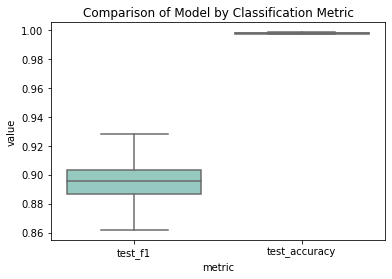

In [12]:
results = pd.melt(results, var_name='metric', value_vars=['test_f1', 'test_accuracy'])
g = sns.boxplot(x="metric", y="value", data=results, palette="Set3")
plt.title('Comparison of Model by Classification Metric')
plt.show()

### Evaluate

In [13]:
X_test.loc[~X_test.type.isin(type_encoder.classes_), 'type'] = "<unknown>"
X_test["type"] = type_encoder.transform(X_test["type"])

In [14]:
X_test = scaler.transform(X_test)

In [15]:
predictions = model.predict(X_test)

f1score = f1_score(y_test, predictions).round(4)
accuracy = accuracy_score(y_test, predictions).round(4)
cm = confusion_matrix(y_test,predictions)

print("F1Score: {}".format(f1score))
print("Accuracy: {}".format(accuracy))
print("Confusion Matrix:\n{}".format(cm))
print()

F1Score: 0.8028
Accuracy: 0.9995
Confusion Matrix:
[[1268336     373]
 [    254    1276]]



/Users/gabriel/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


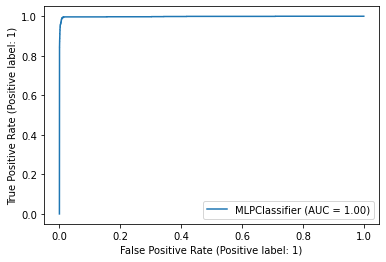

In [16]:
plot_roc_curve(model, X_test, y_test)
plt.show()

### Store Artifacts

In [17]:
def dump_artifact(artifact, artifact_path):
    with open(artifact_path, 'wb') as handle:
        pickle.dump(artifact, handle, protocol=pickle.HIGHEST_PROTOCOL)

artifacts = {
    "type_encoder": type_encoder,
    "model": model,
    "scaler": scaler
}
dump_artifact(artifacts, "../artifacts/artifacts.pkl")